# プロジェクト - 航空会社AIアシスタント

航空会社「FlightAI」のAIカスタマーサポートアシスタントを作成するプロジェクトです。

Jupyter Notebook（week2/day5.ipynb）の内容の概要は以下の通り。

主な流れは以下の通りです：

1. **day4.ipynbの内容**

2. **マルチモーダル化**
   - DALL-E 3（画像生成モデル）を使い、「artist」関数で都市にちなんだ旅行イメージ画像を生成・表示。
   - 画像生成のプロンプトや、base64データの取り扱いを実装。

3. **音声出力**
   - OpenAIの音声APIを使い、テキストから音声（TTS）を生成し再生する「talker」関数を複数の方法で実装。
   - PC/Macごとのトラブルシューティングや、ffmpegなど外部ツールのインストール方法も詳しく説明。

4. **エージェント的な拡張**
   - チャットボットがツールを使い、さらに画像生成や音声出力も組み合わせて返答できるようにし、より「エージェント」的な動きを体験できる内容。
   - Gradioを使い、チャット履歴や画像表示UIも実装。

In [1]:
# import

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# 初期化

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI APIキーが存在し、開始します {openai_api_key[:8]}")
else:
    print("Openai APIキーが設定されていません")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

# 別の方法として、OpenAIの代わりにOllamaを使用したい場合
# Ollamaがローカルで走っていることを確認してください
# MODEL = "llama3.2"
# openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

OpenAI APIキーが存在し、開始します sk-proj-


In [3]:
system_message = "あなたはFlightAIという航空会社の親切なアシスタントです。\
1文以内で、簡潔で丁寧な回答をお願いします。常に正確に回答してください。\
わからない場合は、その旨を伝えてください。"

In [4]:
# この関数は、最新のアップデートを利用しているため、私のビデオの機能よりもかなりシンプルに見えます。

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    # コレはログ
    print("「history」は次のとおりです。")
    print(history)
    print("そして「messages」は次のとおりです。")
    print(messages)
    
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


「history」は次のとおりです。
[]
そして「messages」は次のとおりです。
[{'role': 'system', 'content': 'あなたはFlightAIという航空会社の親切なアシスタントです。1文以内で、簡潔で丁寧な回答をお願いします。常に正確に回答してください。わからない場合は、その旨を伝えてください。'}, {'role': 'user', 'content': 'こんにちは'}]
「history」は次のとおりです。
[{'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どのようにお手伝いできますか？', 'options': None}]
そして「messages」は次のとおりです。
[{'role': 'system', 'content': 'あなたはFlightAIという航空会社の親切なアシスタントです。1文以内で、簡潔で丁寧な回答をお願いします。常に正確に回答してください。わからない場合は、その旨を伝えてください。'}, {'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どのようにお手伝いできますか？', 'options': None}, {'role': 'user', 'content': 'londonに行きたい'}]
「history」は次のとおりです。
[{'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どのようにお手伝いできますか？', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'londonに行きたい'

## ツール（Function calling）

ツールは、フロンティアLLMSが提供する非常に強力な機能です。

ツールを使用すると、関数を記述し、LLMにその機能をその応答の一部として呼び出すことができます。

ほとんど不気味に聞こえます。マシンでコードを実行する力を与えていますか？まあ、ちょっと。

In [5]:
# 役立つ機能を作成することから始めましょう

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    # 辞書 ticket_prices から、指定された都市の料金を取得。辞書にその都市がなければ "Unknown" を返す。
    return ticket_prices.get(city, "Unknown")

In [6]:
# 関数を記述するために必要な特定の辞書構造があります。
#「Function calling」に関連する「関数の定義」部分
#（price_function → get_ticket_price）

price_function = {
    "name": "get_ticket_price",
    "description": "目的地までの往復航空券の料金を取得します。例えば、顧客から「この都市までの航空券はいくらですか？」と尋ねられたときなど、航空券の料金を知りたいときはいつでもこのメソッドを呼び出します。",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "顧客が旅行したい都市",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]

## OpenAIを取得してツールを使用します

OpenAIが「私たちのツールを呼び出す」ことを許可するための厄介なものがいくつかあります

私たちが実際に行っていることは、LLMにツールを実行することを望んでいることを知らせる機会を与えることです。

新しいチャット関数がどのように見えるかは次のとおりです。

In [7]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    # コレはログ
    print("「history」は次のとおりです。")
    print(history)
    print("そして「messages」は次のとおりです。")
    print(messages)
    
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls": # LLMがtools中のprice_functionを使うべきと判断した場合
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [8]:
# その関数をhandle_tool_call：書く必要があります：

def handle_tool_call(message):
    print("responseがtool_callsの場合の「messages」は次のとおりです。")
    print(message)
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    
    # 本来はレイトバインドで呼び出す。
    #price = get_ticket_price(city)
    price = globals()[tool_call.function.name](city)
    
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [9]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


「history」は次のとおりです。
[]
そして「messages」は次のとおりです。
[{'role': 'system', 'content': 'あなたはFlightAIという航空会社の親切なアシスタントです。1文以内で、簡潔で丁寧な回答をお願いします。常に正確に回答してください。わからない場合は、その旨を伝えてください。'}, {'role': 'user', 'content': 'こんにちは'}]
「history」は次のとおりです。
[{'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どのようにお手伝いできますか？', 'options': None}]
そして「messages」は次のとおりです。
[{'role': 'system', 'content': 'あなたはFlightAIという航空会社の親切なアシスタントです。1文以内で、簡潔で丁寧な回答をお願いします。常に正確に回答してください。わからない場合は、その旨を伝えてください。'}, {'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どのようにお手伝いできますか？', 'options': None}, {'role': 'user', 'content': 'londonに行きたい'}]
responseがtool_callsの場合の「messages」は次のとおりです。
ChatCompletionMessage(content='ロンドンまでの往復航空券の料金をお調べしますので、少々お待ちください。', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_g01

# マルチモーダルに行きましょう!!

GPT-4oの背後にある画像生成モデルであるDall-E-3を使用して、画像を作成できます。

これをアーティストと呼ばれる関数に入れましょう。

### 価格アラート：画像を生成するたびに約4セントかかります - 画像に夢中にならないでください！

In [10]:
# 画像を処理するためのいくつかのインポート

import base64
from io import BytesIO
from PIL import Image

In [11]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"{city}での休暇を表現した画像。観光スポットや{city}ならではのユニークな点を、鮮やかなポップアート風に表現しています。",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

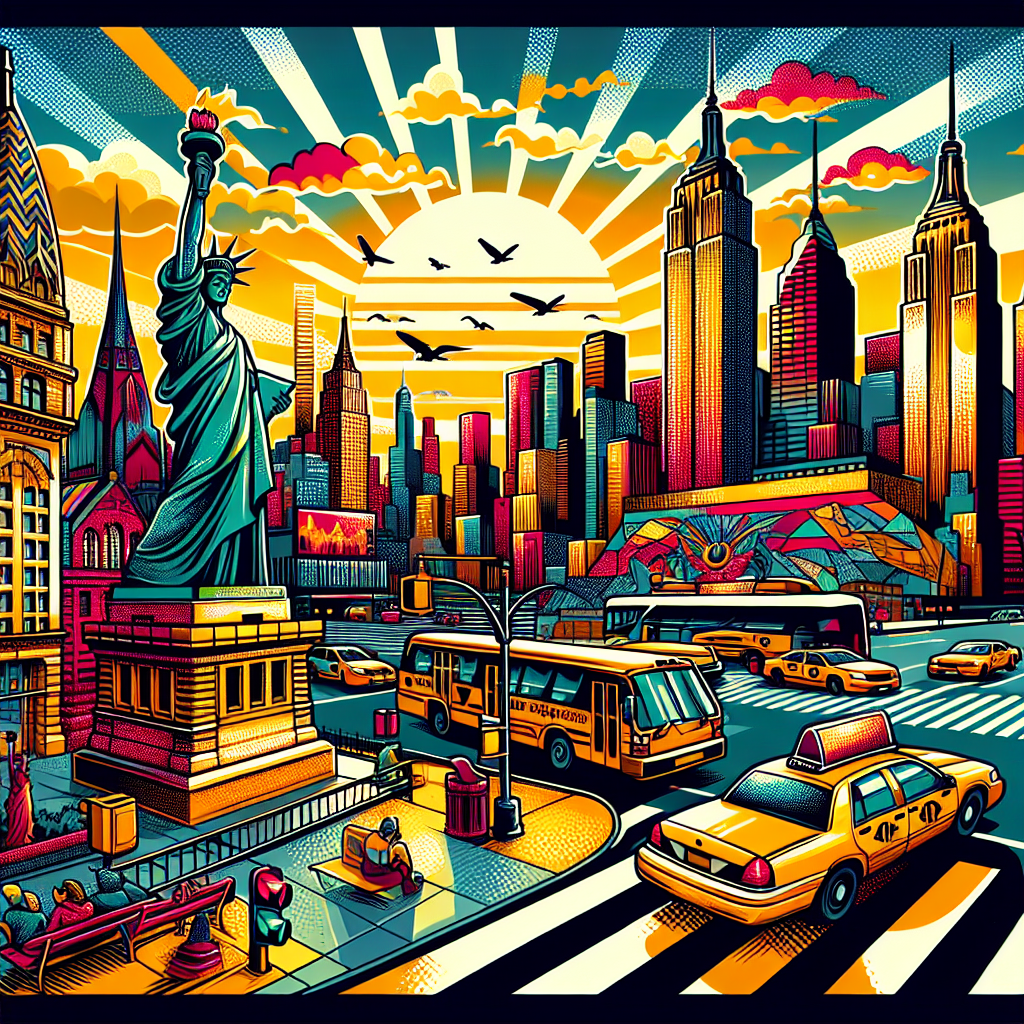

In [12]:
image = artist("New York City")
display(image)

## オーディオ（注 - このコースのオーディオはオプションです - 問題が発生した場合は、オーディオをスキップしてください！）

そして、OpenAIの音声モデルを使用してオーディオを生成する機能トーカーを作りましょう

### トラブルシューティング：オーディオの問題
私は、WindowsでもMACでもなくUbuntuを使用しているので以下でインストール。  
`sudo apt-get -y install ffmpeg`

## ffmpegがインストールされ、ここからアクセスできることを確認するに

次のセルを実行して、バージョン番号が取得されるかどうかを確認します。

In [13]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enable-

# Macユーザーの場合 - そしておそらく多くのPCユーザーも

In [14]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # また、Onyxを合金に置き換えてみてください
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [15]:
talker("こんにちわんこそば")

Input #0, wav, from '/tmp/tmp13sy47e2.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:01.37, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.36 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B f=0/0   

In [16]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # 生成されたオーディオを再生します
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

# エージェントフレームワーク

「エージェントAI」という用語とエージェント化は、次のような多くの手法を指す傘の用語です。

1. 複数のLLMが特別なタスクを実行して、複雑な問題をより小さなステップに分割する
2. LLMSがツールを使用して追加の機能を提供する能力
3. エージェントが協力できる「エージェント環境」
4. LLMはプランナーとして機能し、スペシャリストのために大きなタスクを小さなタスクに分割することができます
5. 自治/代理店を持っているエージェントの概念、プロンプトに単に応答するだけで - メモリなど

ここでは1と2を示していますが、それほどではありません。

In [17]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history

    # コレはログ
    print("「history」は次のとおりです。")
    print(history)
    
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls": # LLMがtools中のprice_functionを使うべきと判断した場合
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city) # 画像生成処理を追加
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    print("「reply」は次のとおりです。")
    print(reply)
    
    history += [{"role":"assistant", "content":reply}]

    # オーディオをスキップしたい場合は、次の行をコメントまたは削除
    talker(reply) # 音声出力処理を追加
    
    return history, image

In [18]:
# プリセットチャットインターフェイスを使用していないため、より複雑なGradioコード！

with gr.Blocks() as ui:
    
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


「history」は次のとおりです。
[{'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}]
「reply」は次のとおりです。
こんにちは！どういったご用件でしょうか？


「history」は次のとおりです。
[{'role': 'user', 'metadata': None, 'content': 'こんにちは', 'options': None}, {'role': 'assistant', 'metadata': None, 'content': 'こんにちは！どういったご用件でしょうか？', 'options': None}, {'role': 'user', 'metadata': None, 'content': 'londonに行きたい', 'options': None}]
responseがtool_callsの場合の「messages」は次のとおりです。
ChatCompletionMessage(content='ロンドンへの往復航空券の料金をお調べしますね。少々お待ちください。', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_2dFaC5HeMejgO9Dlp82dDXPW', function=Function(arguments='{"destination_city":"london"}', name='get_ticket_price'), type='function')])
Tool get_ticket_price called for london
「reply」は次のとおりです。
ロンドンへの往復航空券は約799ドルです。ご希望の出発日などがあれば教えてください。


# 演習とビジネスアプリケーション

より多くのツールを追加する - おそらく実際にフライトを予約するシミュレーション。学生がこれを行って、コミュニティの寄付フォルダーでその例を提供しました。

次：これを取り、それをあなたのビジネスに適用してください。作業のアクティビティを実行できるツールを使用して、マルチモーダルAIアシスタントを作成します。カスタマーサポートアシスタント？新しい従業員のオンボーディングアシスタント？たくさんの可能性！また、別のノートブックの週の終わりのエクササイズを参照してください。

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">特別なお願いがあります。</h2>
            <span style="color:#090;">
                編集者から、Udemyでこのコースを受講生に評価してもらうと、とても大きな違いが出ると言われました。Udemyがこのコースを他の受講生に公開するかどうかを決める主な基準の一つだからです。もし評価していただけるなら、本当に嬉しいです！ いずれにしても、何かお困りのことがあれば、いつでもed@edwarddonner.comまでご連絡ください。
            </span>
        </td>
    </tr>
</table>